In [2]:
from dotenv import load_dotenv
import os
from pathlib import Path
from datetime import datetime, timedelta

import torch
from googleapiclient.discovery import build
import yt_dlp
import whisper
import re
from tqdm import tqdm

import google.generativeai as genai
from langchain.chat_models import ChatOpenAI
from langchain.schema import SystemMessage, HumanMessage

import pandas as pd
from pathlib import Path
import os
import shutil

C:\Users\kk200\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [35]:
folder_path = './preprocessed_data/llm/predict_text'
path_obj = Path(folder_path)

if not path_obj.is_dir():
    print(f"오류: '{folder_path}'는 유효한 폴더 경로가 아닙니다.")

print(f"\n'{folder_path}' 내의 모든 파일 목록 (pathlib 사용):")

dfs = []
for file_path in path_obj.rglob('*.csv'): 
    if file_path.is_file(): # 파일만 선택
        df = pd.read_csv(file_path, encoding='utf-8')
        dfs.append(df)
        
df_t = pd.concat(dfs)
df_t = df_t.sort_values(by=['code', 'year', 'month', 'week'], ascending=True, ignore_index=True)
df_t.to_csv('./preprocessed_data/llm/predict_total/predict_text.csv', encoding='utf-8', index=False)


'./preprocessed_data/llm/predict_text' 내의 모든 파일 목록 (pathlib 사용):


In [15]:
folder_path = './preprocessed_data/llm/predict_video'
path_obj = Path(folder_path)

if not path_obj.is_dir():
    print(f"오류: '{folder_path}'는 유효한 폴더 경로가 아닙니다.")

print(f"\n'{folder_path}' 내의 모든 파일 목록 (pathlib 사용):")

dfs = []
for file_path in path_obj.rglob('*.csv'): 
    if file_path.is_file(): # 파일만 선택
        df = pd.read_csv(file_path, encoding='utf-8')
        dfs.append(df)
        
df_v = pd.concat(dfs)
df_v = df_v.sort_values(by=['code', 'year', 'month', 'week'], ascending=True, ignore_index=True)
df_v.to_csv('./preprocessed_data/llm/predict_total/predict_video.csv', encoding='utf-8', index=False)


'./preprocessed_data/llm/predict_video' 내의 모든 파일 목록 (pathlib 사용):


## 영상 자료가 없는 것 -> 기사로 대체 

In [16]:
df_v = pd.read_csv('./preprocessed_data/llm/predict_total/predict_video.csv', encoding='utf-8')
df_t = pd.read_csv('./preprocessed_data/llm/predict_total/predict_text.csv', encoding='utf-8')
df_v['data'] = 'video'
df_t['data'] = 'article'

nan_list = pd.isna(df_v['prediction'])
not_nan_list = ~pd.isna(df_t['prediction'])
df_v[nan_list & not_nan_list] = df_t[nan_list & not_nan_list]
df_v.to_csv('./preprocessed_data/llm/predict_total/predict_mix.csv', encoding='utf-8', index=False)

## 영상 자료 없는 것 + 중립 -> 기사로 대체

In [17]:
df_v = pd.read_csv('./preprocessed_data/llm/predict_total/predict_video.csv', encoding='utf-8')
df_t = pd.read_csv('./preprocessed_data/llm/predict_total/predict_text.csv', encoding='utf-8')
df_v['data'] = 'video'
df_t['data'] = 'article'

nan_list = pd.isna(df_v['prediction']) | (df_v['prediction'] == '중립')
not_nan_list = ~(pd.isna(df_t['prediction']) | (df_t['prediction'] == '중립'))
df_v[nan_list & not_nan_list] = df_t[nan_list & not_nan_list]
df_v.to_csv('./preprocessed_data/llm/predict_total/predict_mix2.csv', encoding='utf-8', index=False)

## 자료 수집 결측치 확인

In [3]:
print('결측치 비율')
df_v = pd.read_csv('./preprocessed_data/llm/predict_total/predict_video.csv', encoding='utf-8')
df_t = pd.read_csv('./preprocessed_data/llm/predict_total/predict_text.csv', encoding='utf-8')
df_m = pd.read_csv('./preprocessed_data/llm/predict_total/predict_mix.csv', encoding='utf-8')

nan_list = pd.isna(df_v['prediction'])
nan_num = sum(nan_list)
total_num = len(df_v)
print(f'video\t\t결측: {nan_num} / {total_num} = {(nan_num / total_num * 100):.2f}%')

nan_list = pd.isna(df_t['prediction'])
nan_num = sum(nan_list)
total_num = len(df_t)
print(f'text\t\t결측: {nan_num} / {total_num} = {(nan_num / total_num * 100):.2f}%')

nan_list = pd.isna(df_m['prediction'])
nan_num = sum(nan_list)
total_num = len(df_m)
print(f'mix\t\t결측: {nan_num} / {total_num} = {(nan_num / total_num * 100):.2f}%')

############################################################

print('\n중립 비율')
df_v = pd.read_csv('./preprocessed_data/llm/predict_total/predict_video.csv', encoding='utf-8')
df_t = pd.read_csv('./preprocessed_data/llm/predict_total/predict_text.csv', encoding='utf-8')
df_m = pd.read_csv('./preprocessed_data/llm/predict_total/predict_mix.csv', encoding='utf-8')

nan_list = (df_v['prediction'] == '중립')
nan_num = sum(nan_list)
total_num = len(df_v)
print(f'video\t\t중립: {nan_num} / {total_num} = {(nan_num / total_num * 100):.2f}%')

nan_list = (df_t['prediction'] == '중립')
nan_num = sum(nan_list)
total_num = len(df_t)
print(f'text\t\t중립: {nan_num} / {total_num} = {(nan_num / total_num * 100):.2f}%')

nan_list = (df_m['prediction'] == '중립')
nan_num = sum(nan_list)
total_num = len(df_m)
print(f'mix\t\t중립: {nan_num} / {total_num} = {(nan_num / total_num * 100):.2f}%')

결측치 비율
video		결측: 2046 / 5712 = 35.82%
text		결측: 2395 / 5712 = 41.93%
mix		결측: 3348 / 5712 = 58.61%

중립 비율
video		중립: 1949 / 5712 = 34.12%
text		중립: 1602 / 5712 = 28.05%
mix		중립: 1527 / 5712 = 26.73%


## 영상 업로드 일과 일주일 후 가격 비교 confusion matrix

  5%|████▎                                                                               | 295/5712 [00:01<00:24, 224.02it/s]

1978-03-18 00:00:00
1994-01-05 00:00:00


  6%|█████                                                                               | 341/5712 [00:01<00:24, 219.17it/s]

1996-06-18 00:00:00
1992-11-30 00:00:00


 18%|███████████████▏                                                                   | 1048/5712 [00:04<00:21, 215.03it/s]

1996-02-01 00:00:00


 20%|████████████████▌                                                                  | 1137/5712 [00:05<00:21, 215.82it/s]

1997-01-27 00:00:00
1995-03-28 00:00:00
1995-01-27 00:00:00
1998-03-28 00:00:00
1997-03-27 00:00:00


 21%|█████████████████▍                                                                 | 1204/5712 [00:05<00:20, 219.79it/s]

2003-09-23 00:00:00


 34%|████████████████████████████▌                                                      | 1965/5712 [00:08<00:16, 222.99it/s]

2005-03-14 00:00:00


 40%|█████████████████████████████████▎                                                 | 2293/5712 [00:10<00:14, 231.50it/s]

1976-08-14 00:00:00
2001-07-20 00:00:00
1976-03-12 00:00:00
1978-08-16 00:00:00


 41%|██████████████████████████████████▎                                                | 2365/5712 [00:10<00:14, 229.50it/s]

1991-04-08 00:00:00
2001-08-23 00:00:00
1999-02-03 00:00:00


 42%|███████████████████████████████████                                                | 2411/5712 [00:10<00:14, 225.69it/s]

2000-09-07 00:00:00
1994-12-28 00:00:00


 45%|█████████████████████████████████████▍                                             | 2574/5712 [00:11<00:13, 226.85it/s]

1991-08-05 00:00:00
1994-01-20 00:00:00
1999-05-26 00:00:00


 66%|██████████████████████████████████████████████████████▍                            | 3744/5712 [00:16<00:08, 234.80it/s]

1996-07-01 00:00:00
2001-10-30 00:00:00
1978-04-21 00:00:00
1998-01-01 00:00:00


 66%|███████████████████████████████████████████████████████                            | 3792/5712 [00:16<00:08, 228.03it/s]

2001-04-25 00:00:00
2001-11-27 00:00:00
2001-05-30 00:00:00
1974-08-30 00:00:00
2001-05-03 00:00:00
2003-10-08 00:00:00


 67%|███████████████████████████████████████████████████████▊                           | 3838/5712 [00:17<00:08, 219.19it/s]

2002-10-31 00:00:00
2003-10-06 00:00:00
2002-02-05 00:00:00
2001-04-12 00:00:00
1988-05-16 00:00:00
2003-07-18 00:00:00
2001-01-15 00:00:00
2001-10-08 00:00:00


 68%|████████████████████████████████████████████████████████▍                          | 3886/5712 [00:17<00:08, 228.20it/s]

2003-04-21 00:00:00
1995-10-05 00:00:00
1990-01-31 00:00:00
2003-07-03 00:00:00
1991-02-23 00:00:00


 70%|█████████████████████████████████████████████████████████▉                         | 3983/5712 [00:17<00:07, 233.96it/s]

1995-06-26 00:00:00
1989-12-29 00:00:00
2001-10-30 00:00:00
1999-04-13 00:00:00
2001-11-06 00:00:00
1989-02-24 00:00:00
2000-11-23 00:00:00


 71%|██████████████████████████████████████████████████████████▌                        | 4031/5712 [00:17<00:07, 232.38it/s]

2003-01-09 00:00:00
1985-01-29 00:00:00
2003-10-02 00:00:00
2004-09-13 00:00:00
1993-02-10 00:00:00
2002-10-31 00:00:00
2003-10-06 00:00:00
2003-10-07 00:00:00
1998-02-03 00:00:00
2003-10-02 00:00:00
2003-07-15 00:00:00


 71%|███████████████████████████████████████████████████████████▎                       | 4079/5712 [00:18<00:06, 233.82it/s]

2001-08-14 00:00:00
2002-10-22 00:00:00
2002-10-10 00:00:00
2002-06-07 00:00:00


 77%|███████████████████████████████████████████████████████████████▊                   | 4388/5712 [00:19<00:05, 230.08it/s]

1997-01-27 00:00:00


 95%|██████████████████████████████████████████████████████████████████████████████▉    | 5431/5712 [00:23<00:01, 226.91it/s]

1999-04-22 00:00:00


100%|███████████████████████████████████████████████████████████████████████████████████| 5712/5712 [00:25<00:00, 226.87it/s]


ValueError: Length of values (5641) does not match length of index (5712)

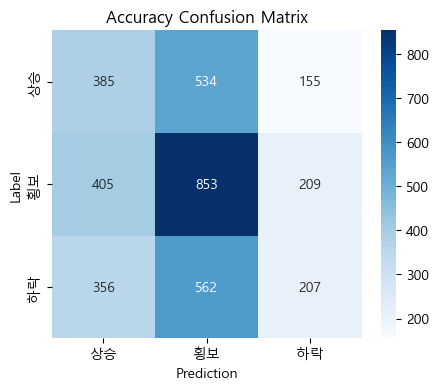

In [12]:
from datetime import timedelta, datetime

change_rate = 2.5 # 주가상승률이 2.5%이상이면 상승, 주가하락률이 2.5%이상이면 하락, 주가변화율이 2.5% 이내면 중립

datas = ['video', 'text', 'mix']
for data in datas:
    df = pd.read_csv(f'preprocessed_data/llm/predict_{data}/predict.csv', encoding='utf-8')
    df['upload_dt'] = pd.to_datetime(df['upload_dt'])
    
    ### LLM 예측에 실제 등락 라벨 추가 ###
    df["code"] = df["code"].astype(str).str.zfill(6)
    
    price_upload = [] # 업로드 당일 종가
    price_after_week = [] # 공시 당일 종가
    for row in tqdm(df.itertuples(), total=len(df)):
        df_price = pd.read_csv(f"data_kr/price/{row.code}.csv")
        df_price['날짜'] = pd.to_datetime(df_price['날짜'])
        ### 업로드 날짜 직전 종가
        try:
            price_upload.append(df_price.loc[df_price["날짜"] < row.upload_dt, "종가"].iloc[-1] if not pd.isna(row.upload_dt) else None)
        except Exception as e:
            print(row.upload_dt)
        ### 업로드 날짜 일주일 후 종가
        after_week_date = row.upload_dt + timedelta(days=7)
        price_after_week.append(df_price.loc[df_price["날짜"] >= after_week_date, "종가"].iloc[0] if not pd.isna(after_week_date) else None)
    
    df["price_upload"] = price_upload
    df["price_after_week"] = price_after_week

    def check_change(row):
        rate = (row["price_after_week"] / row["price_upload"] - 1) * 100
        if rate > change_rate:
            return "상승"
        elif rate < -change_rate:
            return "하락"
        else:
            return "횡보"
    df["label"] = df.apply(check_change, axis=1)
    
    df.to_csv(f"preprocessed_data/llm/predict_{data}/predict_accuracy.csv", index=False, encoding="utf-8")
    
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import confusion_matrix
    
    # 데이터
    valid_bool = ~pd.isna(df['prediction'])
    prediction = df[valid_bool]['prediction']
    label = df[valid_bool]['label']
    
    mapping = {'매우 긍정': '상승', '긍정': '상승', '중립': '횡보', '부정': '하락', '매우 부정': '하락'}
    prediction = [mapping[l] for l in prediction]
    
    # 혼동 행렬
    labels = ["상승", "횡보", "하락"]
    cm = confusion_matrix(label, prediction, labels=labels)
    
    # 한글 폰트 설정 (Windows, Mac, Linux 환경에 맞게 설정)
    # 윈도우
    plt.rc('font', family='Malgun Gothic')
    
    # 시각화
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Prediction')
    plt.ylabel('Label')
    plt.title('Accuracy Confusion Matrix')
    plt.savefig(f"preprocessed_data/llm/predict_{data}/predict_accuracy.png")